In [1]:
import pandas as pd
import numpy as np

In [2]:
path = '../input/wsdm-kkbox/'

def read_csv(csv_name, header_names, with_reducing_mem=False):
  df = pd.read_csv(path + csv_name, delimiter=',', skiprows=1,
                   names=header_names, usecols=header_names, engine='python')
  if not with_reducing_mem:
    return df
  start_mem = df.memory_usage().sum() / 1024**2
  print('Reducing', csv_name, end=':\n')
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  for col in df.columns:
      col_type = df[col].dtype
      if col_type != object:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
      else:
          df[col] = df[col].astype('category')
  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

In [3]:
_train_set = read_csv(
    csv_name='train.csv',
    header_names=['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'target'],
    with_reducing_mem=True)
_members_set = read_csv(
    csv_name='members.csv', 
    header_names=['msno', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date'])
_songs_set = read_csv(
    csv_name='songs.csv', 
    header_names=['song_id' , 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language'])

Reducing train.csv:
Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 84.59 MB
Decreased by 75.0%


In [4]:
_songs_extra_info_set = pd.read_csv(path + 'song_extra_info.csv')

Смержим инфу о юзерах и песнях

In [5]:
train = pd.merge(_train_set, _members_set, on='msno')
train = train.merge(_songs_set, on='song_id')
train = train.merge(_songs_extra_info_set, on='song_id')

train = train.head(int(len(train) * 2 / 3))

import gc
del _train_set, _members_set, _songs_set, _songs_extra_info_set
gc.collect()

27

In [6]:
def refactor_isrc(code):
    if pd.isnull(code):
        return np.nan
    yy = int(str(code)[5:7]) 
    if yy > 17:
        return 1900 + yy
    else:
        return 2000 + yy
train['song_year'] = train['isrc'].apply(refactor_isrc)
train = train.drop(columns=['name', 'isrc'])
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,song_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,2016.0
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,15,18,male,4,20151220,20170930,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,2016.0
2,xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,1,0,NaN,7,20120804,20171004,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,2016.0
3,s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,5,21,female,9,20110808,20170917,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,2016.0
4,Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,0,6,33,female,9,20070323,20170915,206471,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,2016.0


Обработаем NaN значения

In [7]:
display(len(train)) 
train.isna().sum()

4917232

msno                            0
song_id                         0
source_system_tab           17418
source_screen_name         264140
source_type                 14486
target                          0
city                            0
bd                              0
gender                    1955262
registered_via                  0
registration_init_time          0
expiration_date                 0
song_length                     0
genre_ids                   79168
artist_name                     0
composer                   785733
lyricist                  1693052
language                       36
song_year                  262778
dtype: int64

В `source_system_tab`, `source_type`, `language` мало nan-ов, их можно дропнуть

In [8]:
_original_len = len(train)
train = train.dropna(subset=['source_system_tab', 'source_type', 'language'])
f'Left after dropping: {len(train) / _original_len}%'

'Left after dropping: 0.9960833656008096%'

In [9]:
for c in train.source_screen_name.unique():
    print(c)

Explore
Online playlist more
Local playlist more
Discover Chart
Radio
Discover Genre
nan
Discover Feature
Album more
My library
Search
Others profile more
Unknown
My library_Search
Artist more
Search Home
Search Trends
Discover New
Self profile more
Concert
Payment


Есть вариант 'Unknown', подходит, чтобы заменить им nan \
В `gender` nan заменим на значение "undefined"

In [10]:
train = train.fillna({'source_screen_name': 'Unknown', 'gender': 'undefined'})

<AxesSubplot:>

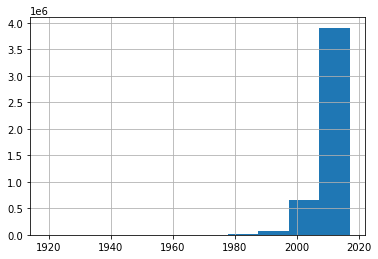

In [11]:
display(train.dropna(subset=['song_year']).song_year.hist())
train = train.fillna({'song_year': train.song_year.mean()})

In [12]:
def get_all_distinct_and_multiple_count(values, seps):
    result = set()
    multi_cnt = 0
    for vs in values:
        if pd.isnull(vs):
            continue
        sep = '|'
        is_multiple = False
        for s in seps:
            if vs.find(s) != -1:
                is_multiple = True
                sep = s
        for v in vs.split(sep):
            result.add(v.strip())
        if is_multiple:
            multi_cnt += 1
    return result, multi_cnt

In [13]:
composers, multi_cnt = get_all_distinct_and_multiple_count(train.composer, seps=['|', '/', '\\', ';'])
f'distinct composers count {len(composers)}, rows count with multiple composers {multi_cnt}'

'distinct composers count 10621, rows count with multiple composers 1254522'

In [14]:
lyricists, multi_cnt = get_all_distinct_and_multiple_count(train.lyricist, seps=['|', '/', '\\', ';'])
f'distinct lyricists count {len(lyricists)}, rows count with multiple lyricists {multi_cnt}'

'distinct lyricists count 5418, rows count with multiple lyricists 829391'

In [15]:
genres, multi_cnt = get_all_distinct_and_multiple_count(train.genre_ids, seps=['|'])
f'distinct genres count {len(genres)}, rows count with multiple genres {multi_cnt}'

'distinct genres count 84, rows count with multiple genres 208458'

In [16]:
del composers, lyricists, genres
gc.collect()

3894

In [17]:
train = train.fillna({'genre_ids': 'no genre', 'lyricist': 'no lyricist', 'composer': 'no composer'})
train.isna().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
song_length               0
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  0
song_year                 0
dtype: int64

Добавим несколько эмбеддингов: 
 - сколько раз песню слушали 
 - процент target=1 на этой песне
 - сколько раз юзер слушал
 - процент target=1 у этого юзера

In [18]:
songs_freq = dict(train.song_id.value_counts())
songs_positive_freq = dict(train[train.target == 1].song_id.value_counts())
members_freq = dict(train.msno.value_counts())
members_positive_freq = dict(train[train.target == 1].msno.value_counts())
train['song_frequency'] = train['song_id'].apply(lambda x: songs_freq[x]).astype(np.float64)
train['song_positive_ratio'] = train['song_id'].apply(
    lambda x: songs_positive_freq[x] / songs_freq[x]
    if x in songs_positive_freq else 0).astype(np.float64)
train['member_frequency'] = train['msno'].apply(lambda x: members_freq[x]).astype(np.float64)
train['member_positive_ratio'] = train['msno'].apply(
    lambda x: members_positive_freq[x] / members_freq[x]
    if x in members_positive_freq else 0).astype(np.float64)

del songs_freq, songs_positive_freq, members_freq, members_positive_freq
gc.collect()

train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,genre_ids,artist_name,composer,lyricist,language,song_year,song_frequency,song_positive_ratio,member_frequency,member_positive_ratio
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,undefined,7,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52.0,2016.0,215.0,0.474419,5508.0,0.506536
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,0,15,18,male,4,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52.0,2016.0,215.0,0.474419,748.0,0.505348
2,xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,1,0,undefined,7,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52.0,2016.0,215.0,0.474419,436.0,0.917431
3,s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,5,21,female,9,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52.0,2016.0,215.0,0.474419,349.0,0.931232
4,Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,0,6,33,female,9,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52.0,2016.0,215.0,0.474419,824.0,0.234223


In [19]:
labels = train['target']
train = train.drop(columns=['target'])

In [20]:
train.dtypes

msno                        object
song_id                     object
source_system_tab         category
source_screen_name        category
source_type               category
city                         int64
bd                           int64
gender                      object
registered_via               int64
registration_init_time       int64
expiration_date              int64
song_length                  int64
genre_ids                   object
artist_name                 object
composer                    object
lyricist                    object
language                   float64
song_year                  float64
song_frequency             float64
song_positive_ratio        float64
member_frequency           float64
member_positive_ratio      float64
dtype: object

In [21]:
cat_features = ['source_system_tab', 'source_screen_name', 'source_type', 'city', 'gender', 
                'registered_via', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language']
cat_features_indices = [train.columns.get_loc(cf) for cf in cat_features]
print(cat_features_indices)
train['language'] = train['language'].apply(int)
train.head()

[2, 3, 4, 5, 7, 8, 12, 13, 14, 15, 16]


,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,...,genre_ids,artist_name,composer,lyricist,language,song_year,song_frequency,song_positive_ratio,member_frequency,member_positive_ratio
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0,undefined,7,20120102,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,5508.0,0.506536
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,discover,Online playlist more,online-playlist,15,18,male,4,20151220,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,748.0,0.505348
2,xbodnNBaLMyqqI7uFJlvHOKMJaizuWo/BB/YHZICcKo=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,1,0,undefined,7,20120804,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,436.0,0.917431
3,s0ndDsjI79amU0RBiullFN8HRz9HjE++34jGNa7zJ/s=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,5,21,female,9,20110808,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,349.0,0.931232
4,Vw4Umh6/qlsJDC/XMslyAxVvRgFJGHr53yb/nrmY1DU=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,my library,Local playlist more,local-library,6,33,female,9,20070323,...,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,824.0,0.234223


In [22]:
!pip install catboost

In [23]:
import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [24]:
params = {
    'iterations': 250,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'verbose': 125
}

In [25]:
def kfold(X, y, splits, params):
    sum_auc = 0
    for train_index, test_index in KFold(n_splits=splits).split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = cb.CatBoostClassifier(iterations=params['iterations'],
                                      learning_rate=params['learning_rate'],
                                      eval_metric=params['eval_metric'],
                                      task_type=params['task_type'],
                                      verbose=params['verbose'])
        model.fit(X_train, y_train, cat_features=cat_features_indices)
        del X_train, y_train
        gc.collect()

        predict = model.predict(X_test)
        auc = roc_auc_score(y_test, predict)
        print("AUC =", auc)
        sum_auc += auc
    
        del X_test, y_test, model, predict
        gc.collect()
    return sum_auc / splits 

In [26]:
train_ids = pd.DataFrame()
train_ids['msno'] = train.msno
train_ids['song_id'] = train.song_id
display(train_ids.head(2))

train = train.drop(columns=['msno', 'song_id'])
display(train.head(2))

gc.collect()

for i in range(len(cat_features_indices)):
    cat_features_indices[i] -= 2

,msno,song_id
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=
1,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=


,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,song_year,song_frequency,song_positive_ratio,member_frequency,member_positive_ratio
0,explore,Explore,online-playlist,1,0,undefined,7,20120102,20171005,206471,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,5508.0,0.506536
1,discover,Online playlist more,online-playlist,15,18,male,4,20151220,20170930,206471,359,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,748.0,0.505348


In [27]:
gc.collect()
kfold(train, labels, splits=5, params=params)

TRAIN: [ 979595  979596  979597 ... 4897970 4897971 4897972] TEST: [     0      1      2 ... 979592 979593 979594]
0:	learn: 0.6872504	total: 441ms	remaining: 1m 49s
125:	learn: 0.7637733	total: 49.9s	remaining: 49.1s
249:	learn: 0.7675215	total: 1m 40s	remaining: 0us
AUC = 0.682462226696291
TRAIN: [      0       1       2 ... 4897970 4897971 4897972] TEST: [ 979595  979596  979597 ... 1959187 1959188 1959189]
0:	learn: 0.6926497	total: 385ms	remaining: 1m 35s
125:	learn: 0.7670924	total: 49.2s	remaining: 48.4s
249:	learn: 0.7716247	total: 1m 39s	remaining: 0us
AUC = 0.6817443286015071
TRAIN: [      0       1       2 ... 4897970 4897971 4897972] TEST: [1959190 1959191 1959192 ... 2938782 2938783 2938784]
0:	learn: 0.6936235	total: 372ms	remaining: 1m 32s
125:	learn: 0.7687165	total: 49.7s	remaining: 48.9s
249:	learn: 0.7729238	total: 1m 40s	remaining: 0us
AUC = 0.6821887484248207
TRAIN: [      0       1       2 ... 4897970 4897971 4897972] TEST: [2938785 2938786 2938787 ... 3918376 391

0.6828276997058965

In [28]:
from gensim.models import Word2Vec

In [29]:
class MusicW2V:

    def _get_members_info(self, X, y):
        members = X.msno.unique()
        members2id = {members[i]: i for i in range(len(members))}
        members_playlist = [[] for _ in range(len(members))]
        for i, row in X.iterrows():
            if y[i] == 1:
                members_playlist[members2id[row['msno']]].append(row['song_id'])
        return members, members2id, members_playlist

    def __init__(self, X, y, vec_size=64, window=5, workers=3, min_count=2):
        self.vec_size = vec_size
        self.members, self.members2id, self.members_playlist = self._get_members_info(X, y)
        self.songs = X.song_id.unique()
        self.model = Word2Vec(sentences=self.members_playlist, 
                              vector_size=self.vec_size, 
                              window=window, 
                              workers=workers, 
                              min_count=min_count)
  
    def show_similar_songs(self, songs_df, index, topn=5):
        print('Similars for:\n')
        print(songs_df.loc[index])
        print(f'\nMost similar (Top {topn}):\n')
        similars = self.model.wv.most_similar(songs_df.loc[index, 'song_id'], topn=topn)
        for song_id, _ in similars:
            display(songs_df.loc[songs_df['song_id'] == song_id])

    def predict(self, X):
        members2vec = [np.mean([self.model.wv[song_id] for song_id in playlist], 
                               axis=0) if playlist 
                       else np.zeros(self.vec_size) 
                       for playlist in self.members_playlist]
        cosines = []
        for i, row in X.iterrows():
            member, song_id = row['msno'], row['song_id']
            member_vec = members2vec[self.members2id[member]] if member in self.members2id else np.zeros(self.vec_size)
            song_vec = self.model.wv[song_id] if song_id in self.model.wv else np.zeros(self.vec_size)
            dot = member_vec @ song_vec
            cosines.append(dot / (np.linalg.norm(member_vec) * np.linalg.norm(song_vec)))
        return cosines

In [30]:
w2v_params = {
    'vec_size': 100,
    'window': 5,
    'workers': 4,
    'min_count': 1
}

Треним на 4/5 датасета, предиктим на 1/5

In [31]:
perm = np.random.permutation(train_ids.index)
w2v_train = train_ids.reindex(perm)
w2v_labels = labels.reindex(perm)
predict_size = int(len(w2v_train) / 5)
gc.collect()
w2v_model = MusicW2V(w2v_train[:-predict_size], 
                     w2v_labels[:-predict_size], 
                     vec_size=w2v_params['vec_size'], 
                     window=w2v_params['window'],
                     workers=w2v_params['workers'],
                     min_count=w2v_params['min_count'])

In [32]:
_songs_set = read_csv(
    csv_name='songs.csv', 
    header_names=['song_id' , 'song_length', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language'])
w2v_model.show_similar_songs(_songs_set, 1391177, topn=6)

Similars for:

song_id        BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=
song_length                                          206471
genre_ids                                               359
artist_name                                        Bastille
composer                               Dan Smith| Mark Crew
lyricist                                                NaN
language                                                 52
Name: 1391177, dtype: object

Most similar (Top 6):



,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
1038202,668yKmgsC8bh/RvuS1qx5hS0pw2WgUCpF8Un7XWglFE=,227840,1609,Jess Glynne,Grace Chatto| James Napier,NaN,52.0


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
64383,psIWGc2dmV+p2Dr2O6aj4MOuhnvZ9r6ejEBzjPFefWE=,167026,1609,Era Istrefi,Era Istrefi,NaN,52.0


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
105951,DmtrK7g2JddypVbwBURM2+MYontD7YTQAbu9zhWbLKU=,229862,1609|2107,Snakehips,Oliver Dickinson|James David|Chancelor J Bennett,Oliver Dickinson|James David|Chancelor J Bennett,52.0


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
14826,WIoW1oEtCJuBEIPLvjc1T+wCwFwoV2CbCSbiJr0JYkI=,200306,1609,Rain Man,Kris Trindl| Lianna Sylvan| Mat Devine,NaN,52.0


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
73678,pXe+m+hSMB1VFKape9+EmhGXnUOthXS0foVYjgFF9Bs=,211800,1011,Maren Morris,Maren Morris| busbee,Maren Morris| busbee,52.0


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
65800,rm8uElgcFJDOeR0vipTSkw84zuUTdLEwldwikkemK6o=,242520,1609,Rudimental,Ed Sheeran|Amir Amor|James Newman|Kesi Dryden|...,NaN,52.0


In [33]:
del _songs_set
gc.collect()

49

In [34]:
w2v_predict = w2v_model.predict(w2v_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [35]:
w2v_predict = [0.0 if np.isnan(x) else x for x in w2v_predict]

In [36]:
w2v_auc = roc_auc_score(w2v_labels[-predict_size:], w2v_predict[-predict_size:])
print("AUC =", w2v_auc)

AUC = 0.5939286989194704


In [37]:
del w2v_model
gc.collect()

88

Стек w2v + CatBoost

In [38]:
train['w2v'] = w2v_predict[:len(train)]
train.head(2)

,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,...,artist_name,composer,lyricist,language,song_year,song_frequency,song_positive_ratio,member_frequency,member_positive_ratio,w2v
0,explore,Explore,online-playlist,1,0,undefined,7,20120102,20171005,206471,...,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,5508.0,0.506536,0.920520
1,discover,Online playlist more,online-playlist,15,18,male,4,20151220,20170930,206471,...,Bastille,Dan Smith| Mark Crew,no lyricist,52,2016.0,215.0,0.474419,748.0,0.505348,0.579021


In [39]:
gc.collect()
kfold(train, labels, splits=5, params=params)

TRAIN: [ 979595  979596  979597 ... 4897970 4897971 4897972] TEST: [     0      1      2 ... 979592 979593 979594]
0:	learn: 0.6872504	total: 381ms	remaining: 1m 34s
125:	learn: 0.7631718	total: 49.4s	remaining: 48.6s
249:	learn: 0.7676919	total: 1m 39s	remaining: 0us
AUC = 0.6849625449915171
TRAIN: [      0       1       2 ... 4897970 4897971 4897972] TEST: [ 979595  979596  979597 ... 1959187 1959188 1959189]
0:	learn: 0.6926497	total: 380ms	remaining: 1m 34s
125:	learn: 0.7671555	total: 49.7s	remaining: 48.9s
249:	learn: 0.7715101	total: 1m 39s	remaining: 0us
AUC = 0.6801154168045349
TRAIN: [      0       1       2 ... 4897970 4897971 4897972] TEST: [1959190 1959191 1959192 ... 2938782 2938783 2938784]
0:	learn: 0.6936235	total: 370ms	remaining: 1m 32s
125:	learn: 0.7687745	total: 49.8s	remaining: 49s
249:	learn: 0.7728891	total: 1m 39s	remaining: 0us
AUC = 0.6808661659439469
TRAIN: [      0       1       2 ... 4897970 4897971 4897972] TEST: [2938785 2938786 2938787 ... 3918376 3918

0.6824936485086456

In [40]:
!pip install shap
import shap

In [41]:
train, labels = train.head(int(len(train) / 3)), labels.head(int(len(labels) / 3))
del w2v_train, w2v_labels
gc.collect()

22

In [42]:
shap_model = cb.CatBoostClassifier(iterations=params['iterations'],
                                   learning_rate=params['learning_rate'],
                                   eval_metric=params['eval_metric'],
                                   task_type=params['task_type'],
                                   verbose=params['verbose'])
shap_model.fit(train, labels, cat_features=cat_features_indices)

0:	learn: 0.6985781	total: 251ms	remaining: 1m 2s
125:	learn: 0.7741114	total: 19.6s	remaining: 19.3s
249:	learn: 0.7773483	total: 38.9s	remaining: 0us


In [43]:
df2shap = train.head(5000).copy()
del train, labels
gc.collect()

22

In [44]:
shap_test = shap.TreeExplainer(shap_model).shap_values(df2shap)

In [45]:
del shap_model
gc.collect()

22

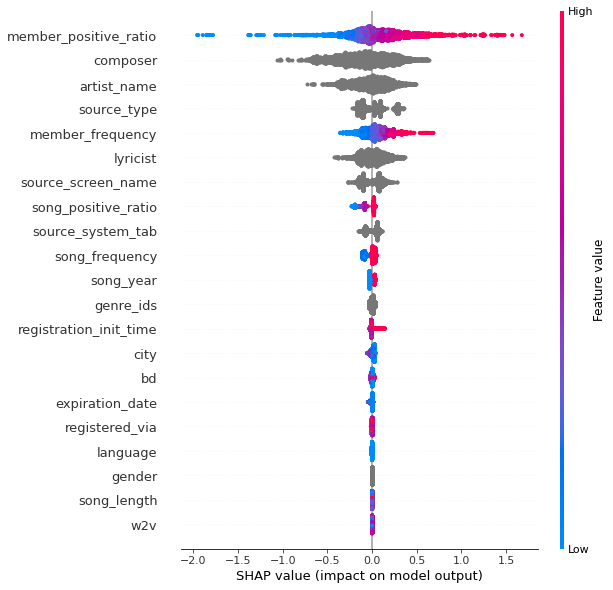

In [46]:
shap.summary_plot(shap_test, df2shap, max_display=25)